In [1]:
import numpy as np 
import csv
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
# from lib.nn import*
from lib.plot import *
import pickle
from scipy.optimize import minimize,Bounds,SR1, rosen, shgo
from scipy import optimize
from scipy.optimize import rosen, differential_evolution
import pickle


control_result = []
# torch.manual_seed(10)
# np.random.seed(10)

path = "D:\\USC_google_drive\\DOE project\\Aveva_adaptive"
os.chdir(path)

class Net1(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(5, 20)  # 5*5 from image dimension
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 2)
#         self.fc4 = nn.Linear(50, 5)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Net2(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(5, 20)  # 5*5 from image dimension
        self.fc2 = nn.Linear(20, 30)
        self.fc3 = nn.Linear(30, 2)
#         self.fc4 = nn.Linear(50, 5)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Net3(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(5, 20)  # 5*5 from image dimension
        self.fc2 = nn.Linear(20, 40)
        self.fc3 = nn.Linear(40, 2)
#         self.fc4 = nn.Linear(50, 5)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Net4(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(5, 20)  # 5*5 from image dimension
        self.fc2 = nn.Linear(20, 50)
        self.fc3 = nn.Linear(50, 2)
#         self.fc4 = nn.Linear(50, 5)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [2]:
learning_rate = [0.05,0.01,0.005,0.001]

RMSE = []
MAPE = [] 
RMSE_d = []
MAPE_d = [] 
data = np.genfromtxt('data/gen1.csv', delimiter=',')[1:,:]
data = data.astype(np.float32)
with open('data/gen1.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    header= reader.fieldnames
header = [key for key in header]

datax = np.load('randomSample.npy')

dataypos = [0,12]
datay = data[:,dataypos]
data = np.hstack((datax,datay))
modelname0 = '3/modeltemp'

Train = True

header1= header[:5]
header2= header[5:]
data = data[:3000,:]

scaler = pickle.load(open('scaler2.pkl','rb'))
datan = scaler.transform(data)
datan = datan.astype(np.float32)
trainlen =2000
train = datan[:trainlen,:]
test = datan[trainlen:,:]
header = ['brine_p','brine_t','brine_q','pump speed','ambient T','Power','Cost']



for j in range(4):
    Net = Net3
    RMSE1 = []
    MAPE1 = []
    lr_c = learning_rate[j]
    for i in range(10):
        print('current'+str(j)+str(i))
        modelname =modelname0  +str(j)+str(i)+'.pt'
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
        net = Net().to(device)    # transfer model to GPU if available
        net = net.train()   # set model in train mode (eg batchnorm params get updated)
        if True:
#             opt = optim.Adam(net.parameters(), lr=lr_c)       # create optimizer instance
            criterion = nn.MSELoss()    
            train_it = 0
            best_loss = 100
            batch_size = 16
            epochs = 100
            val_loss = []
            rec_loss = []
            vallen = int(trainlen*0.7)
            for ep in range(epochs):
                opt = optim.Adam(net.parameters(), lr=lr_c)    
                np.random.seed(int(time.time()))
                trainl = np.arange(len(train))
                np.random.shuffle(trainl)
                int(trainlen*0.7)
                traintemp = train[trainl[:vallen],:] 
                val = train[trainl[vallen:],:] 
                val = torch.from_numpy(val)
                traintemp = torch.from_numpy(traintemp)
    #             print("Run Epoch {}".format(ep))

                Trains = torch.utils.data.DataLoader(traintemp,batch_size=batch_size)    

                for Train in Trains:
                    train_x = Train[:,:5]
                    train_y = Train[:,5:]
                    opt.zero_grad()
                    outputs = net(train_x)
                    # loss
                    total_loss = criterion(outputs, train_y)

                    # backward
                    total_loss.backward()
                    # update the weights
                    opt.step()

                    if train_it % 1000 == 0:
                        print("It {}: Reconstruction Loss: {}".format(train_it, total_loss))
                    train_it += 1


                val_output = net(val[:,:5]) 
                val_loss1 = criterion(val_output,val[:,5:])
                val_loss.append(val_loss1)
                train_output = net(traintemp[:,:5])
                total_loss = criterion(train_output, traintemp[:,5:])
                rec_loss.append(total_loss)

    #             print("It {}: Validation Loss: {}".format(ep, val_loss1))
                if val_loss1 < best_loss:
                    torch.save(net.state_dict(), './history/m_structure/'+modelname)
                    best_loss = val_loss1

        net = Net().to(device)
        net.load_state_dict(torch.load('./history/m_structure/'+modelname))
        net = net.eval() 
        testx = torch.from_numpy(test[:,:5])
        pred = net(testx).detach().numpy()
        testy = test[:,5:]

        temp = np.ma.masked_invalid(np.abs(pred-testy)/testy)
        mse = np.round(np.sqrt(np.mean((pred- testy)**2,axis =0)),3)
        mae = np.round(np.mean(temp,axis =0),3)

        print(mse)
        print(mae)

        RMSE1.append(mse)
        MAPE1.append(mae)
    RMSE.append(np.mean(RMSE1))
    MAPE.append(np.mean(MAPE1))
    RMSE_d.append(np.std(RMSE1))
    MAPE_d.append(np.std(MAPE1))  

current00
It 0: Reconstruction Loss: 0.4001086354255676
It 1000: Reconstruction Loss: 0.0011467176955193281
It 2000: Reconstruction Loss: 0.00043428331264294684
It 3000: Reconstruction Loss: 0.003216423327103257
It 4000: Reconstruction Loss: 0.0016244577709585428
It 5000: Reconstruction Loss: 0.0006524522905237973
It 6000: Reconstruction Loss: 0.002842281013727188
It 7000: Reconstruction Loss: 0.0014627391938120127
It 8000: Reconstruction Loss: 0.0016008475795388222


C:\Users\Wei_L\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in true_divide


[0.031 0.028]
[0.054 0.074]
current01
It 0: Reconstruction Loss: 0.23158638179302216
It 1000: Reconstruction Loss: 0.0011451358441263437
It 2000: Reconstruction Loss: 0.0019023115746676922
It 3000: Reconstruction Loss: 0.00819101557135582
It 4000: Reconstruction Loss: 0.0013959537027403712
It 5000: Reconstruction Loss: 0.002915859455242753
It 6000: Reconstruction Loss: 0.006606149487197399
It 7000: Reconstruction Loss: 0.002276355866342783
It 8000: Reconstruction Loss: 0.0030967015773057938
[0.046 0.028]
[0.091 0.102]
current02
It 0: Reconstruction Loss: 0.2698656916618347
It 1000: Reconstruction Loss: 0.002356886398047209
It 2000: Reconstruction Loss: 0.000619121827185154
It 3000: Reconstruction Loss: 0.006847386248409748
It 4000: Reconstruction Loss: 0.0010609669843688607
It 5000: Reconstruction Loss: 0.0004740656295325607
It 6000: Reconstruction Loss: 0.005406574346125126
It 7000: Reconstruction Loss: 0.00543410237878561
It 8000: Reconstruction Loss: 0.000885092536918819
[0.033 0.02

It 4000: Reconstruction Loss: 0.0001434505102224648
It 5000: Reconstruction Loss: 0.000141732714837417
It 6000: Reconstruction Loss: 0.0015871546929702163
It 7000: Reconstruction Loss: 0.00010470167035236955
It 8000: Reconstruction Loss: 0.00026765585062094033
[0.021 0.017]
[0.029 0.028]
current18
It 0: Reconstruction Loss: 0.16765053570270538
It 1000: Reconstruction Loss: 0.00046099486644379795
It 2000: Reconstruction Loss: 0.0001685087918303907
It 3000: Reconstruction Loss: 0.0007942641386762261
It 4000: Reconstruction Loss: 0.0005901021067984402
It 5000: Reconstruction Loss: 0.00022472100681625307
It 6000: Reconstruction Loss: 0.000614073418546468
It 7000: Reconstruction Loss: 0.00016832136316224933
It 8000: Reconstruction Loss: 0.00040553027065470815
[0.018 0.019]
[0.026 0.033]
current19
It 0: Reconstruction Loss: 0.2426883429288864
It 1000: Reconstruction Loss: 0.0004271426296327263
It 2000: Reconstruction Loss: 0.0002639102458488196
It 3000: Reconstruction Loss: 0.001736338483169

It 7000: Reconstruction Loss: 8.331511344294995e-05
It 8000: Reconstruction Loss: 6.814948574174196e-05
[0.019 0.017]
[0.027 0.025]
current34
It 0: Reconstruction Loss: 0.22812971472740173
It 1000: Reconstruction Loss: 0.00019256709492765367
It 2000: Reconstruction Loss: 0.00010093831951962784
It 3000: Reconstruction Loss: 0.0002264475915580988
It 4000: Reconstruction Loss: 8.133087976602837e-05
It 5000: Reconstruction Loss: 0.00017408265557605773
It 6000: Reconstruction Loss: 0.000297029095236212
It 7000: Reconstruction Loss: 0.00029711914248764515
It 8000: Reconstruction Loss: 5.7480254326947033e-05
[0.018 0.017]
[0.022 0.022]
current35
It 0: Reconstruction Loss: 0.35385265946388245
It 1000: Reconstruction Loss: 0.0007291402434930205
It 2000: Reconstruction Loss: 0.00044731440721079707
It 3000: Reconstruction Loss: 0.00019624116248451173
It 4000: Reconstruction Loss: 0.00022778441780246794
It 5000: Reconstruction Loss: 0.00027800103998743
It 6000: Reconstruction Loss: 4.0960840124171

In [3]:
RMSE_d

[0.00815414, 0.00096306775, 0.001410673, 0.0009937297]

([<matplotlib.axis.XTick at 0x2062a59ee08>,
 [Text(0.15, 0, '1'),
  Text(1.15, 0, '2'),
  Text(2.15, 0, '3'),
  Text(3.15, 0, '4')])

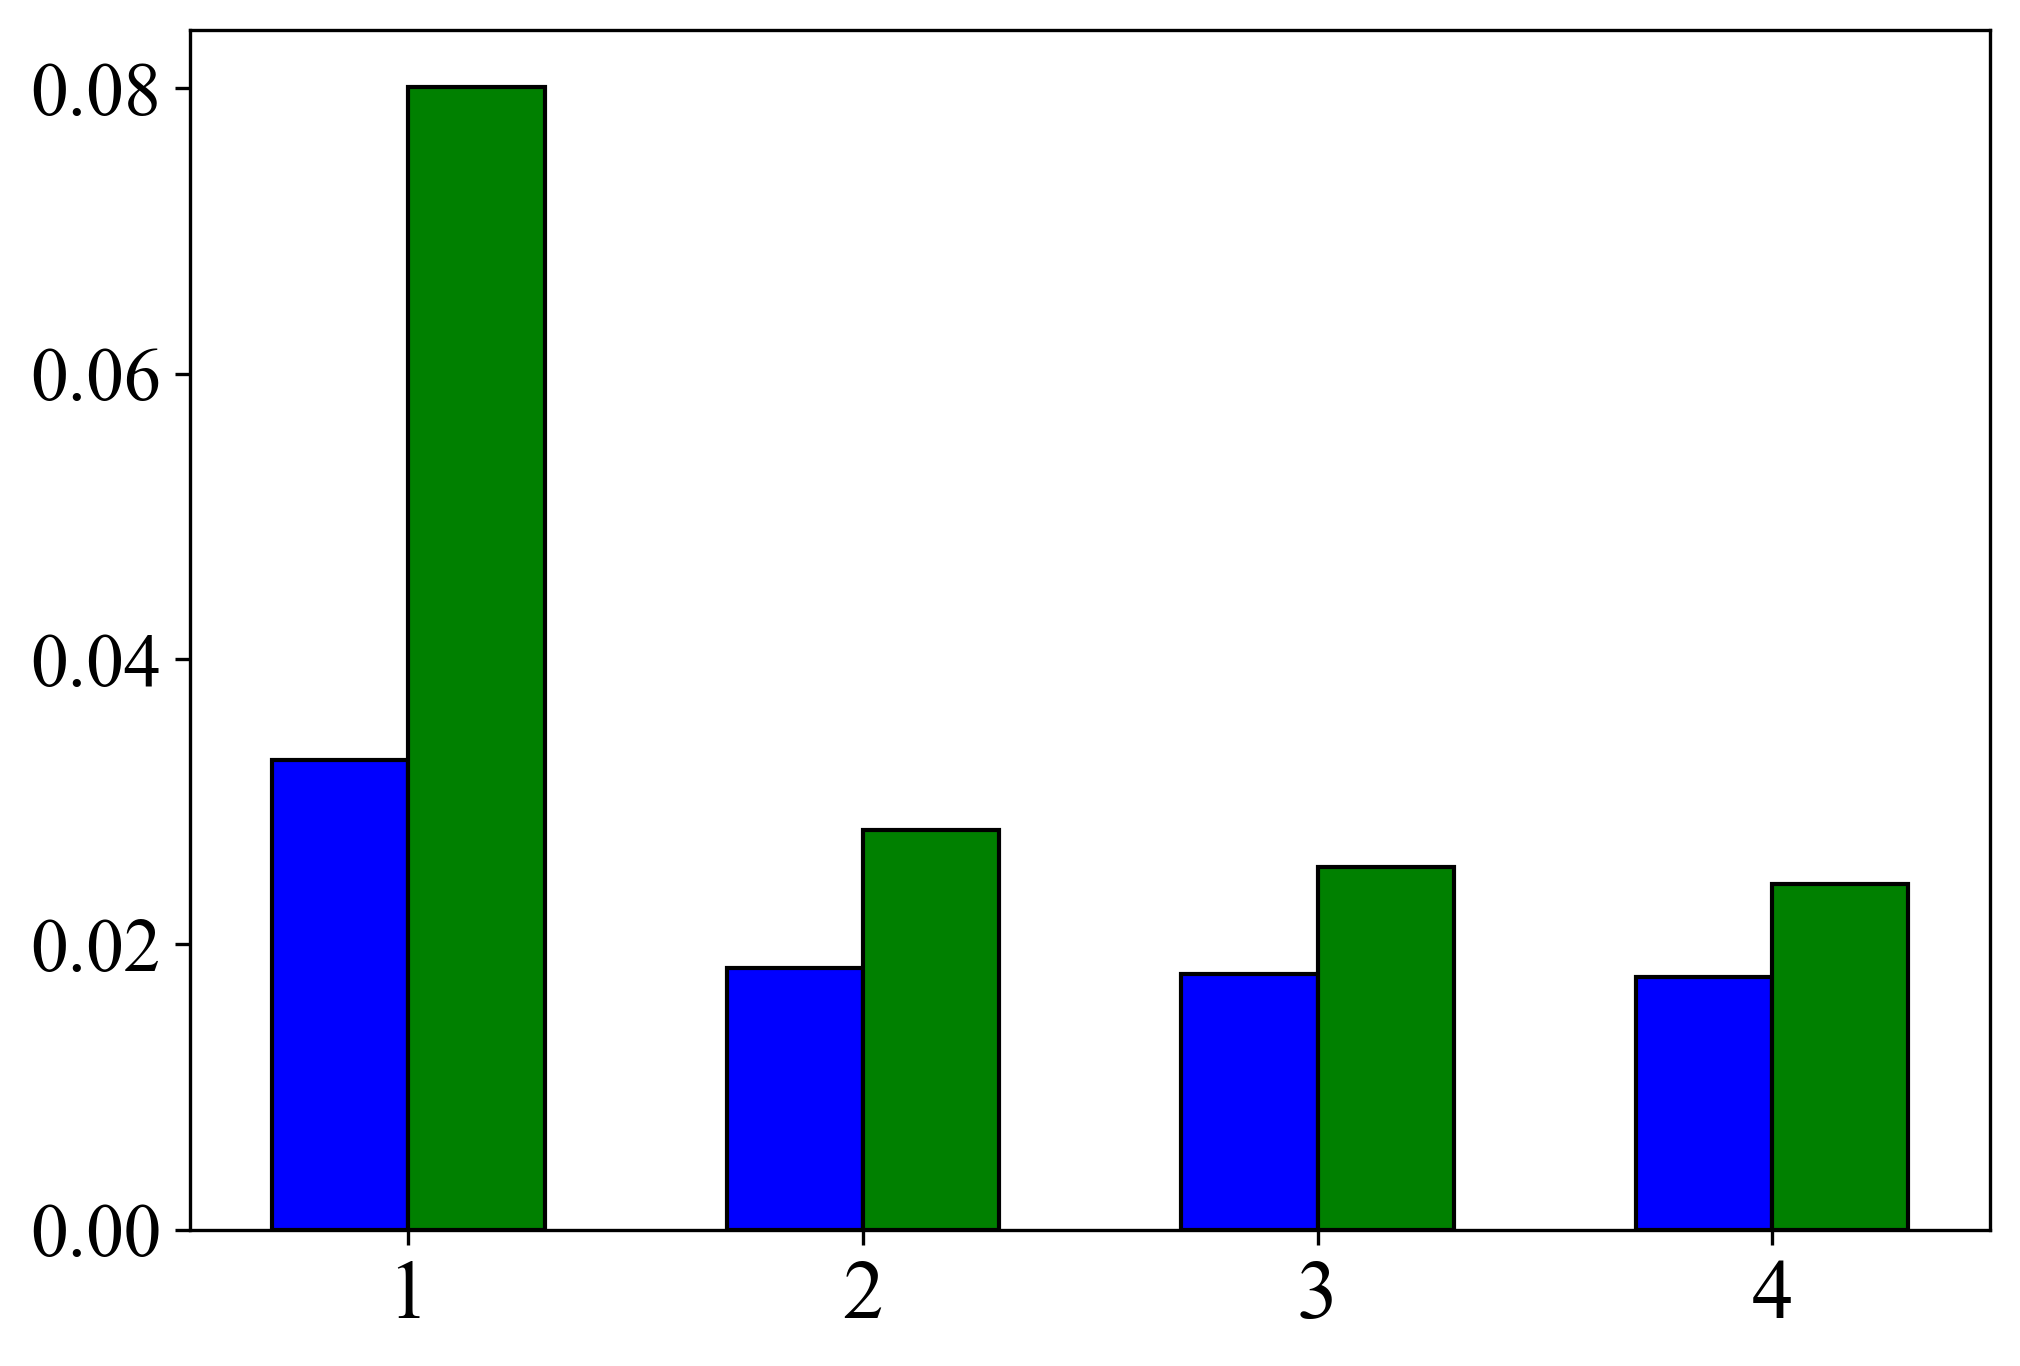

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '18'
plt.rcParams["font.family"] = "Times New Roman"
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


barWidth = 0.3

r1 = np.arange(4)
r2 = [x + barWidth for x in r1]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(r1, RMSE, color = 'b',width=barWidth, edgecolor='black',label = 'RMSE')
ax.bar(r2, MAPE, color = 'g', width=barWidth, edgecolor='black',label = 'MAPE')
# plt.errorbar(r1, RMSE, yerr = RMSE_d,fmt='.',ecolor = 'black',color='black', markersize=5, capsize=10)
# plt.errorbar(r2, MAPE, yerr = MAPE_d,fmt='.',ecolor = 'black',color='black', markersize=5, capsize=10)
plt.xticks([r + barWidth/2 for r in range(4)], ['1', '2', '3','4'],fontsize =20)

In [5]:
data = np.genfromtxt('data/longsimple1.csv', delimiter=',')[1:,:]
data = data.astype(np.float32)
with open('data/longsimple1.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    header= reader.fieldnames
header = [key for key in header]


header1= header[:5]
header2= header[5:]

data[:,-1] = data[:,-2]- data[:,-1]

data = data[-1500:,:]
test = scaler.transform(data)


_RMSE = []
_MAPE = [] 
_RMSE_d = []
_MAPE_d = [] 

for j in range(4):
    modelname =modelname0  +str(j)+str(i)+'.pt'
    RMSE1 = []
    MAPE1=[]
    Net = Net3
    for i in range(5):
        net = Net().to(device)
        net.load_state_dict(torch.load('./history/m_structure/'+modelname))
        net = net.eval() 
        testx = torch.from_numpy(test[:,:5])
        pred = net(testx).detach().numpy()
        testy = test[:,5:]

        temp = np.ma.masked_invalid(np.abs(pred-testy)/testy)
        mse = np.round(np.sqrt(np.mean((pred - testy)**2,axis =0)),3)
        mae = np.round(np.mean(temp,axis =0),3)
        RMSE1.append(mse)
        MAPE1.append(mae)
    _RMSE.append(np.mean(RMSE1))
    _MAPE.append(np.mean(MAPE1))
    _RMSE_d.append(np.std(RMSE1))
    _MAPE_d.append(np.std(MAPE1))  

In [6]:
RMSE1 = []
MAPE1=[]
for k in range(5):
    modelname = '2/modeltemp3'+ str(k)+'.pt'
    Net = Net3
    net = Net().to(device)
    net.load_state_dict(torch.load('./history/m_structure/'+modelname))
    net = net.eval() 
    testx = torch.from_numpy(test[:,:5])
    pred = net(testx).detach().numpy()
    testy = test[:,5:]

    temp = np.ma.masked_invalid(np.abs(pred-testy)/testy)
    mse = np.round(np.sqrt(np.mean((pred - testy)**2,axis =0)),3)
    mae = np.round(np.mean(temp,axis =0),3)
    RMSE1.append(mse)
    MAPE1.append(mae)




In [7]:
RMSE1

[array([0.008, 0.019], dtype=float32),
 array([0.013, 0.006], dtype=float32),
 array([0.015, 0.015], dtype=float32),
 array([0.009, 0.013], dtype=float32),
 array([0.008, 0.006], dtype=float32)]

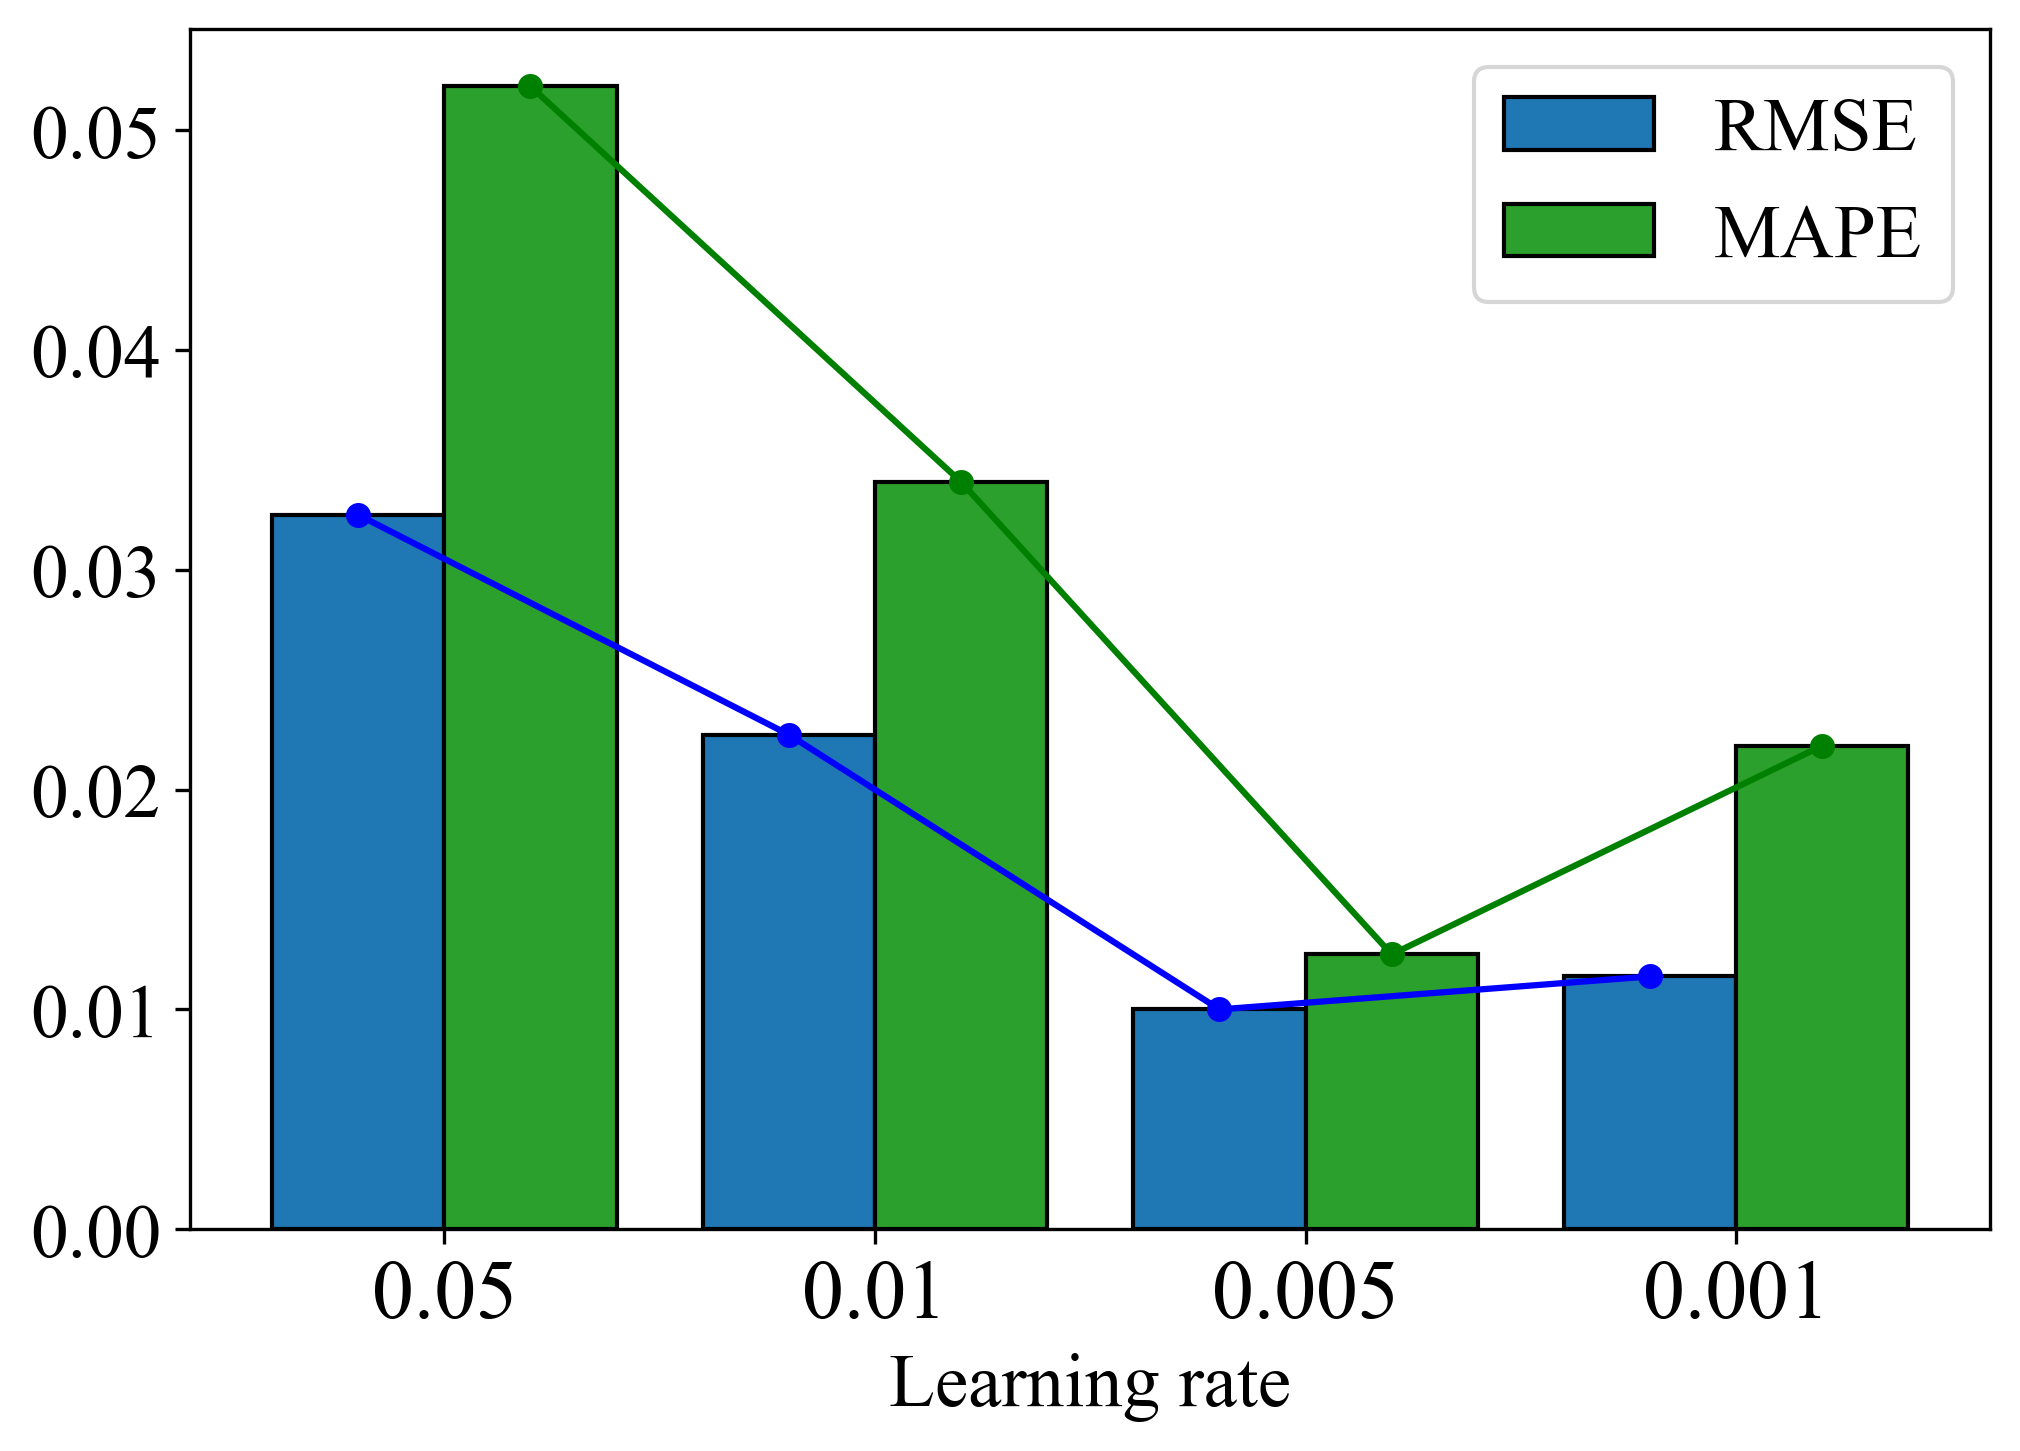

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '18'
plt.rcParams["font.family"] = "Times New Roman"
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


barWidth = 0.4

r1 = np.arange(4)
r2 = [x + barWidth for x in r1]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(r1, _RMSE, color = 'tab:blue',width=barWidth, edgecolor='black',label = 'RMSE')
ax.bar(r2,_MAPE, color = 'tab:green', width=barWidth, edgecolor='black',label = 'MAPE')
plt.plot(r1,_RMSE,'.-',markersize=10,color = 'b')
plt.plot(r2,_MAPE,'.-',ms = 10,color = 'g')
plt.xticks([r+barWidth/2 for r in range(4)], ['0.05','0.01','0.005','0.001'],fontsize =20)
plt.xlabel('Learning rate')
plt.legend()

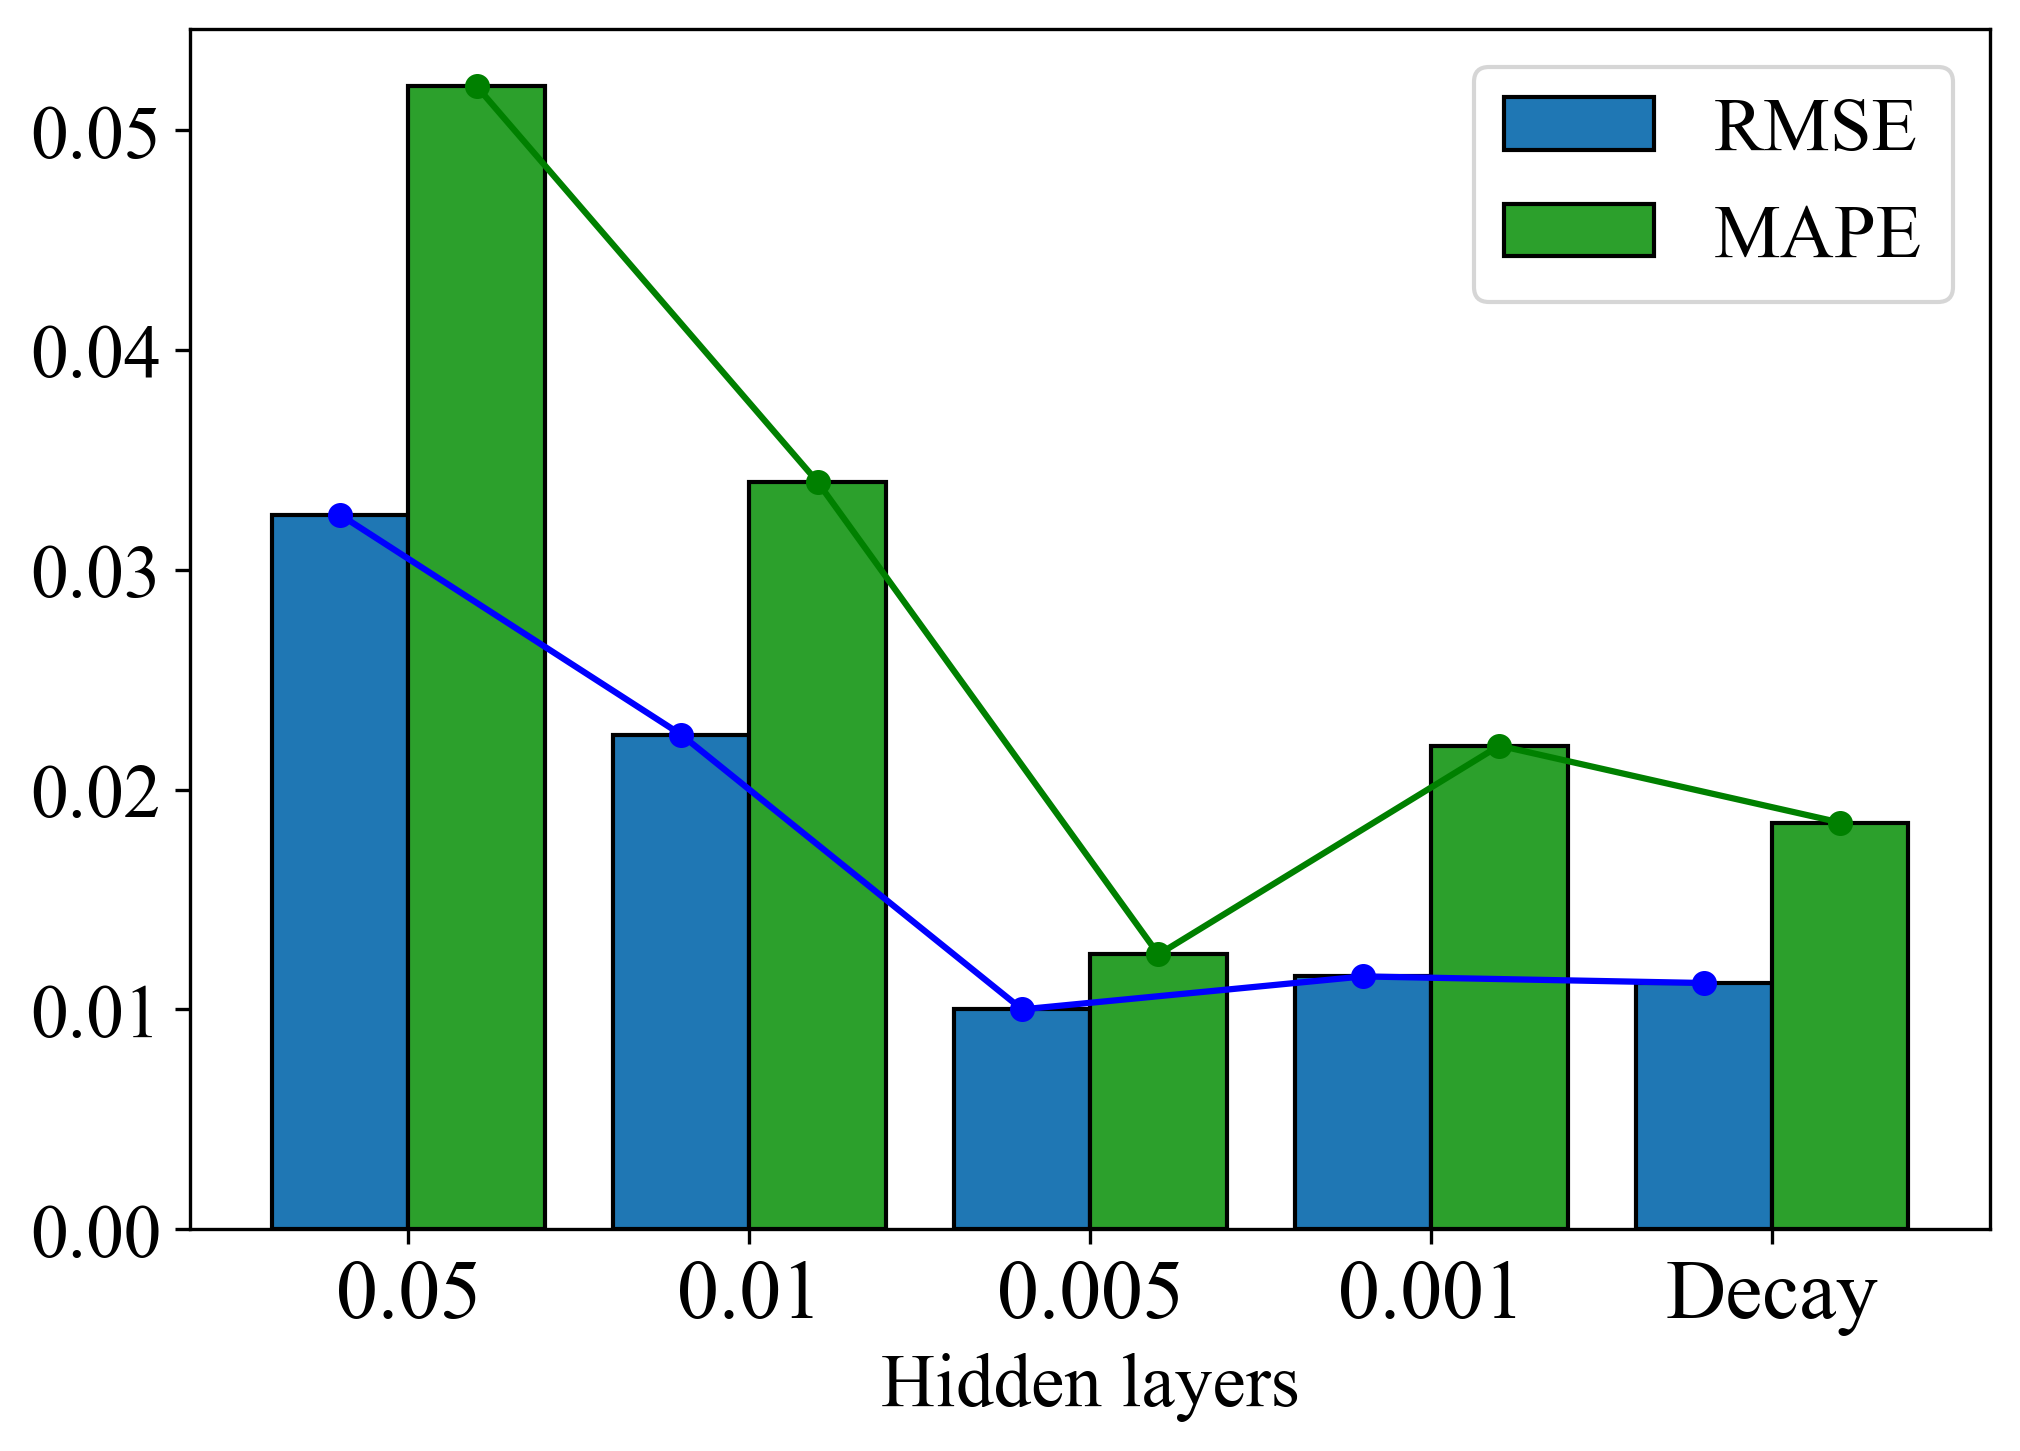

In [9]:
_RMSE.append(np.mean(RMSE1))
_MAPE.append(np.mean(MAPE1))

barWidth = 0.4

r1 = np.arange(5)
r2 = [x + barWidth for x in r1]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(r1, _RMSE, color = 'tab:blue',width=barWidth, edgecolor='black',label = 'RMSE')
ax.bar(r2,_MAPE, color = 'tab:green', width=barWidth, edgecolor='black',label = 'MAPE')
plt.plot(r1,_RMSE,'.-',markersize=10,color = 'b')
plt.plot(r2,_MAPE,'.-',ms = 10,color = 'g')
plt.xticks([r+barWidth/2 for r in range(5)], ['0.05','0.01','0.005','0.001','Decay'],fontsize =20)
plt.xlabel('Hidden layers')
plt.legend()